# Reddit_Analysis_2977771D

This Notebook will show how to analyze Reddit community data (using the InvestmentClub subforum as an example). The notebook is divided into four main parts:

1. **Data Processing and Aggregation**  
2. **Network Construction and Visualization**  
3. **Network Data Analysis**  
4. **Topic Analysis and Sentiment Analysis**  

In the first three parts, I am focusing on the structure of user comments, relationships between comments and posts, and the creation of an interaction network. In the fourth part, I am deepening the topic modeling on all posts using NMF and PyLDAVis, exploring the time dimension, and combining the results with the existing network data. And I also perform a degree of sentiment analysis to explore how user sentiment affects engagement.

## 1. Data Processing and Aggregation

I begin by loading all necessary libraries and reading in the data. I then clean the data by removing deleted items and converting timestamps where applicable.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from datetime import datetime
from collections import Counter
import warnings
import re
import nltk
import spacy
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import textstat
warnings.filterwarnings('ignore')

# Ensures NLTK resources are available
try:
    nltk.data.find('vader_lexicon')
except LookupError:
    nltk.download('vader_lexicon')

# Loads spaCy model
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    import subprocess
    subprocess.run(["python", "-m", "spacy", "download", "en_core_web_sm"])
    nlp = spacy.load("en_core_web_sm")

sia = SentimentIntensityAnalyzer()

# Use a style and palette that differ from typical usage
plt.style.use('ggplot')
sns.set_palette("PuOr")
plt.rcParams['figure.figsize'] = (12, 8)

print("All libraries have been loaded.")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


All libraries have been loaded.


### 1.1 Loading Data
I load the refined JSON files for both comments and submissions. I also load a stopword file for potential text processing.

In [2]:
comments_path = r"F:\\UofG\\daily\\Semester 2\\Web Science\\coursework_ws\\Data\\InvestmentClub_comments_refined.json"
submissions_path = r"F:\\UofG\\daily\\Semester 2\\Web Science\\coursework_ws\\Data\\InvestmentClub_submissions_refined.json"
stopword_path = r"F:\\UofG\\daily\\Semester 2\\Web Science\\coursework_ws\\Data\\stopwordFile.txt"

with open(stopword_path, 'r', encoding='utf-8') as sf:
    stop_words = set(sf.read().split())

comments_df = pd.read_json(comments_path)
submissions_df = pd.read_json(submissions_path)

print("Number of comments:", len(comments_df))
print("Columns in comments:", comments_df.columns.tolist())
print("\nNumber of submissions:", len(submissions_df))
print("Columns in submissions:", submissions_df.columns.tolist())

Number of comments: 22863
Columns in comments: ['controversiality', 'downs', 'id', 'score', 'score_hidden', 'name', 'edited', 'body', 'subreddit_id', 'created_utc', 'gilded', 'author_flair_css_class', 'ups', 'retrieved_on', 'parent_id', 'author_flair_text', 'link_id', 'author', 'archived', 'subreddit', 'distinguished', 'removal_reason', 'report_reasons', 'created', 'approved_by', 'num_reports', 'body_html', 'likes', 'replies', 'mod_reports', 'user_reports', 'saved', 'banned_by', 'stickied', 'can_gild', 'approved_at_utc', 'can_mod_post', 'collapsed', 'collapsed_reason', 'banned_at_utc', 'is_submitter', 'author_cakeday', 'permalink', 'subreddit_type', 'mod_note', 'mod_reason_by', 'mod_reason_title', 'no_follow', 'send_replies', 'author_flair_template_id', 'author_flair_background_color', 'author_flair_text_color', 'rte_mode', 'author_flair_richtext', 'author_flair_type', 'author_created_utc', 'author_fullname', 'subreddit_name_prefixed', 'gildings', 'author_patreon_flair', 'quarantined',

### 1.2 Basic Cleaning and Timestamp Conversion
I remove rows with `[deleted]` or `[removed]` in key fields, and I convert `created_utc` to a proper DateTime type.

In [3]:
def clean_content(df, is_comment=True):
    df = df.copy()
    df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s', errors='coerce')
    markers = {"[deleted]", "[removed]"}
    if is_comment:
        # remove if author or body is in the marker set
        filtered = df[~(df['author'].isin(markers) | df['body'].isin(markers))].copy()
    else:
        # remove if author or title or selftext is in the marker set
        filtered = df[~(df['author'].isin(markers) | df['title'].isin(markers) | df['selftext'].isin(markers))].copy()
    return filtered

comments_clean = clean_content(comments_df, is_comment=True)
submissions_clean = clean_content(submissions_df, is_comment=False)

print("Comments after cleaning:", len(comments_clean))
print("Submissions after cleaning:", len(submissions_clean))

Comments after cleaning: 20172
Submissions after cleaning: 13509


### 1.3 Data Overview
I examine how many submission IDs appear in the comments and whether there are references to submissions not in the data.

In [4]:
submission_ids = set(submissions_clean['id'])
comment_links = comments_clean['link_id'].dropna().tolist()
comment_sub_ids = set(x[3:] for x in comment_links if x.startswith('t3_'))
common_subs = submission_ids.intersection(comment_sub_ids)

print("Number of unique IDs in submission data:", len(submission_ids))
print("Number of unique submission IDs referenced in comments:", len(comment_sub_ids))
print("Intersection:", len(common_subs))

outside_subs = comment_sub_ids - submission_ids
print("Referenced in comments but not in submissions:", len(outside_subs))

# Distinguish direct replies vs nested replies
direct_replies = comments_clean[comments_clean['parent_id'].astype(str).str.startswith('t3_')]
nested_replies = comments_clean[comments_clean['parent_id'].astype(str).str.startswith('t1_')]
print(f"Number of direct replies to submissions: {len(direct_replies)}")
print(f"Number of replies to other comments: {len(nested_replies)}")

# Controversial comments
controversial_comments = comments_clean[comments_clean['controversiality'] > 0]
print(f"Number of controversial comments: {len(controversial_comments)}")

Number of unique IDs in submission data: 13509
Number of unique submission IDs referenced in comments: 5986
Intersection: 4591
Referenced in comments but not in submissions: 1395
Number of direct replies to submissions: 12079
Number of replies to other comments: 8093
Number of controversial comments: 160


### 1.4 Comment-Post Relationship Analysis
I examine how each comment references a post or another comment via `parent_id`. I also verify which submissions exist in my data.

In [5]:
print(" Comment-Post Relationship Analysis Code ")
direct_only = comments_clean[comments_clean['parent_id'].astype(str).str.startswith('t3_', na=False)]
nested_only = comments_clean[comments_clean['parent_id'].astype(str).str.startswith('t1_', na=False)]
print("Direct replies (comments -> posts):", len(direct_only))
print("Nested replies (comments -> comments):", len(nested_only))

valid_submission_ids = set(submissions_clean['id'])
direct_submission_ids = set([pid[3:] for pid in direct_only['parent_id']])
valid_direct_ids = direct_submission_ids.intersection(valid_submission_ids)
print("Number of direct parent IDs truly in submissions:", len(valid_direct_ids))
invalid_direct_ids = direct_submission_ids - valid_submission_ids
print("Number of direct references pointing outside of my known submissions:", len(invalid_direct_ids))
print("Done with comment-post relationship analysis.")

 Comment-Post Relationship Analysis Code 
Direct replies (comments -> posts): 12079
Nested replies (comments -> comments): 8093
Number of direct parent IDs truly in submissions: 4566
Number of direct references pointing outside of my known submissions: 1390
Done with comment-post relationship analysis.


### 1.5 Building User Interaction DataFrame
I build a DataFrame of all user interactions `(source, target, type, post_id, timestamp)`. This is necessary for constructing the network.

In [6]:
def extract_interactions(cdf, pdf):
    # Builds user edge data
    user_edges = []
    post_author_map = dict(zip(pdf['id'], pdf['author']))
    comment_author_map = dict(zip(cdf['id'], cdf['author']))
    comment_link_map = dict(zip(cdf['id'], cdf['link_id']))

    for idx, row in cdf.iterrows():
        c_author = row['author']
        p_id = row.get('parent_id','')
        time_val = row['created_utc']
        if isinstance(p_id, str):
            if p_id.startswith('t3_'):
                sub_id = p_id[3:]
                if sub_id in post_author_map:
                    s_author = post_author_map[sub_id]
                    if s_author != c_author:
                        user_edges.append((c_author, s_author, 'comment_to_post', sub_id, time_val))
            elif p_id.startswith('t1_'):
                par_cid = p_id[3:]
                if par_cid in comment_author_map:
                    par_author = comment_author_map[par_cid]
                    linkval = comment_link_map.get(par_cid, '')
                    link_id = linkval[3:] if isinstance(linkval, str) and linkval.startswith('t3_') else None
                    if par_author != c_author:
                        user_edges.append((c_author, par_author, 'comment_to_comment', link_id, time_val))

    df_interactions = pd.DataFrame(
        user_edges,
        columns=['source_user','target_user','type','post_id','timestamp']
    )
    df_interactions.drop_duplicates(inplace=True)
    return df_interactions

interaction_df = extract_interactions(comments_clean, submissions_clean)
print("Total interactions:", len(interaction_df))
interaction_df.head(10)

Total interactions: 16862


,source_user,target_user,type,post_id,timestamp
0,hobbitskill,Zurevu,comment_to_post,p6dut,2012-02-01 18:13:16
1,withacupofcoffee,hobbitskill,comment_to_comment,p6dut,2012-02-01 18:15:16
2,hobbitskill,Zurevu,comment_to_post,p6dut,2012-02-01 19:14:11
3,Zurevu,hobbitskill,comment_to_comment,p6dut,2012-02-01 19:41:29
4,Zurevu,bobbyt2012,comment_to_post,p6fpo,2012-02-01 20:20:24
5,keezel,DarkHydra,comment_to_post,p6ll4,2012-02-01 20:51:01
6,Workahol,Zurevu,comment_to_post,p6dut,2012-02-01 21:40:26
7,Zurevu,Workahol,comment_to_comment,p6dut,2012-02-01 21:50:40
8,ttg314,Waterwoo,comment_to_post,p6qgm,2012-02-01 22:23:42
9,AutonomousMonkey,Delepie,comment_to_post,p6mhb,2012-02-01 22:30:18


# 2. Network Construction and Visualization

In this section, I convert the interaction DataFrame into a directed graph, visualize the entire network or a subset, and then delve into more detail about sub-networks. This will help me understand the structure of the community.

## 2.1 Defining Network Analysis Helper Functions
I define functions for basic statistics, for analyzing degrees or connectivity, which I will use in the subsequent steps.

In [7]:
def basic_network_stats(G):
    # Calculates basic properties of a directed network
    stats = {
        'node_count': G.number_of_nodes(),
        'edge_count': G.number_of_edges(),
        'density': nx.density(G)
    }
    return stats

def degree_distribution_values(G):
    out_vals = [v for (_,v) in G.out_degree()]
    in_vals = [v for (_,v) in G.in_degree()]
    return out_vals, in_vals

def connectivity_analysis(G):
    # Returns number of weakly and strongly connected components.
    weak = list(nx.weakly_connected_components(G))
    strong = list(nx.strongly_connected_components(G))
    result = {
        'weak_cc_count': len(weak),
        'strong_cc_count': len(strong)
    }
    return result

def path_analysis(G):
    # Finds largest WCC and tries average path length.
    wcc_list = list(nx.weakly_connected_components(G))
    if wcc_list:
        largest_wcc = max(wcc_list, key=len)
        subg = G.subgraph(largest_wcc).copy()
        try:
            apl = nx.average_shortest_path_length(subg.to_undirected())
            return apl
        except:
            return None
    else:
        return None

def compute_centralities(G):
    # Returns multiple centrality measures
    cent_dict = {}
    cent_dict['degree'] = dict(G.degree())
    try:
        btw_c = nx.betweenness_centrality(G)
        cent_dict['betweenness'] = btw_c
    except:
        cent_dict['betweenness'] = {}
    try:
        eig_c = nx.eigenvector_centrality(G, max_iter=2000)
        cent_dict['eigenvector'] = eig_c
    except:
        cent_dict['eigenvector'] = {}
    try:
        closeness_c = nx.closeness_centrality(G)
        cent_dict['closeness'] = closeness_c
    except:
        cent_dict['closeness'] = {}
    return cent_dict

def identify_key_users(cent_dict, top_n=20):
    # Sort each metric, return top N
    result = {}
    for metric, dmap in cent_dict.items():
        sorted_list = sorted(dmap.items(), key=lambda x: x[1], reverse=True)
        result[metric] = sorted_list[:top_n]
    return result

## 2.2 Building the User Interaction Network
I now create a directed network from the `interaction_df`.

In [8]:
G_main = nx.DiGraph()
for i, row in interaction_df.iterrows():
    su = row['source_user']
    tu = row['target_user']
    rel = row['type']
    if not G_main.has_node(su):
        G_main.add_node(su)
    if not G_main.has_node(tu):
        G_main.add_node(tu)
    if not G_main.has_edge(su, tu):
        G_main.add_edge(su, tu, weight=1, relation=rel)
    else:
        G_main[su][tu]['weight'] += 1

print("Nodes in main graph:", G_main.number_of_nodes())
print("Edges in main graph:", G_main.number_of_edges())

Nodes in main graph: 7734
Edges in main graph: 13473


## 2.3 Defining Network Visualization Function
I define a function that can visualize either the entire network or a subgraph based on the top nodes by degree centrality.

In [9]:
import math
from matplotlib.lines import Line2D
def plot_network(G, top_n=None, custom_title=None):
    deg_c = nx.degree_centrality(G)
    if top_n and top_n < G.number_of_nodes():
        top_nodes = sorted(deg_c.items(), key=lambda x: x[1], reverse=True)[:top_n]
        chosen = [n[0] for n in top_nodes]
        subG = G.subgraph(chosen).copy()
        ttl = f"Top {top_n} sub-network"
    else:
        subG = G
        ttl = "Complete Reddit User Interaction Network"
    if custom_title:
        ttl = custom_title
    node_count = subG.number_of_nodes()
    cent_vals = [deg_c.get(n,0) for n in subG.nodes()]
    mval = max(cent_vals) if cent_vals else 1
    node_sizing = [50 + (v/mval)*2000 for v in cent_vals]

    layout_positions = nx.spring_layout(
        subG,
        seed=42,
        k=0.15*math.sqrt((300 if node_count>300 else node_count)/float(node_count))
    )

    plt.figure(figsize=(14,10))
    cvals = plt.cm.cividis
    node_draw = nx.draw_networkx_nodes(
        subG,
        layout_positions,
        node_size=node_sizing,
        node_color=cent_vals,
        cmap=cvals,
        alpha=0.9,
        linewidths=0.5,
        edgecolors='black'
    )

    edge_colors = []
    for (u,v,d) in subG.edges(data=True):
        if d.get('relation')=='comment_to_post':
            edge_colors.append('cornflowerblue')
        else:
            edge_colors.append('orange')

    nx.draw_networkx_edges(
        subG,
        layout_positions,
        edge_color=edge_colors,
        arrows=True,
        arrowstyle='->',
        alpha=0.6,
        width=1.0
    )

    if node_count<=50:
        nx.draw_networkx_labels(subG, layout_positions, font_size=8)

    cbar = plt.colorbar(
        plt.cm.ScalarMappable(cmap=cvals),
        shrink=0.8
    )
    cbar.set_label('Degree Centrality', fontsize=12)

    legend_elems = [
        Line2D([0],[0], color='cornflowerblue', lw=2, label='comment_to_post'),
        Line2D([0],[0], color='orange', lw=2, label='comment_to_comment')
    ]
    plt.legend(handles=legend_elems, loc='upper right')
    plt.title(ttl)
    plt.axis('off')
    plt.show()

## 2.4 Full Network Visualization
I will visualize the complete network, but this might be visually dense because there is a lot data.

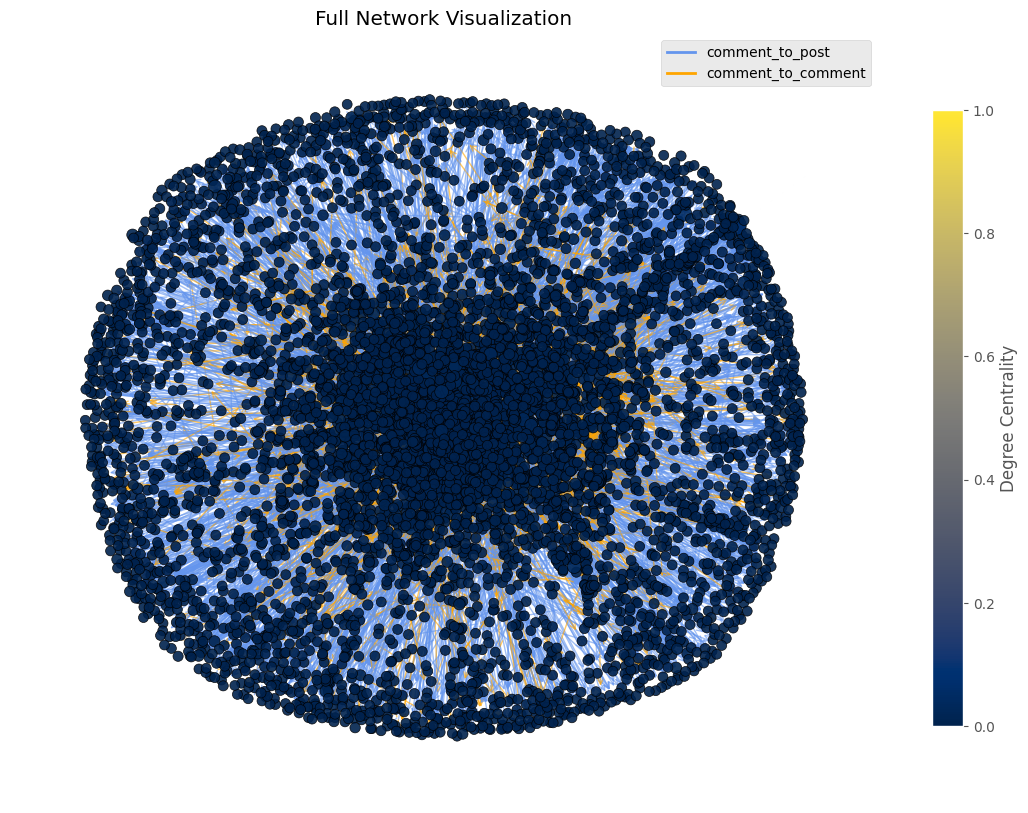

In [10]:
# Full network visualization
plot_network(G_main, top_n=None, custom_title="Full Network Visualization")

## 2.5 Core Sub-Network Visualization
I then visualize the top 100 and top 30 sub-networks (by degree centrality).

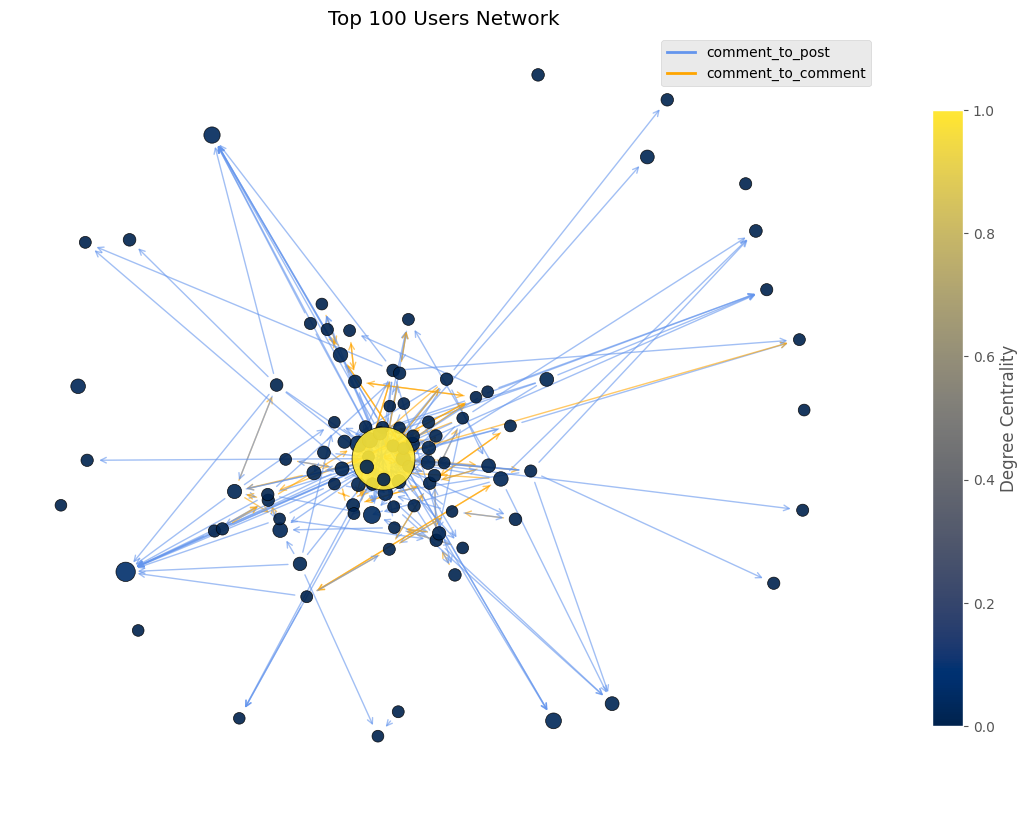

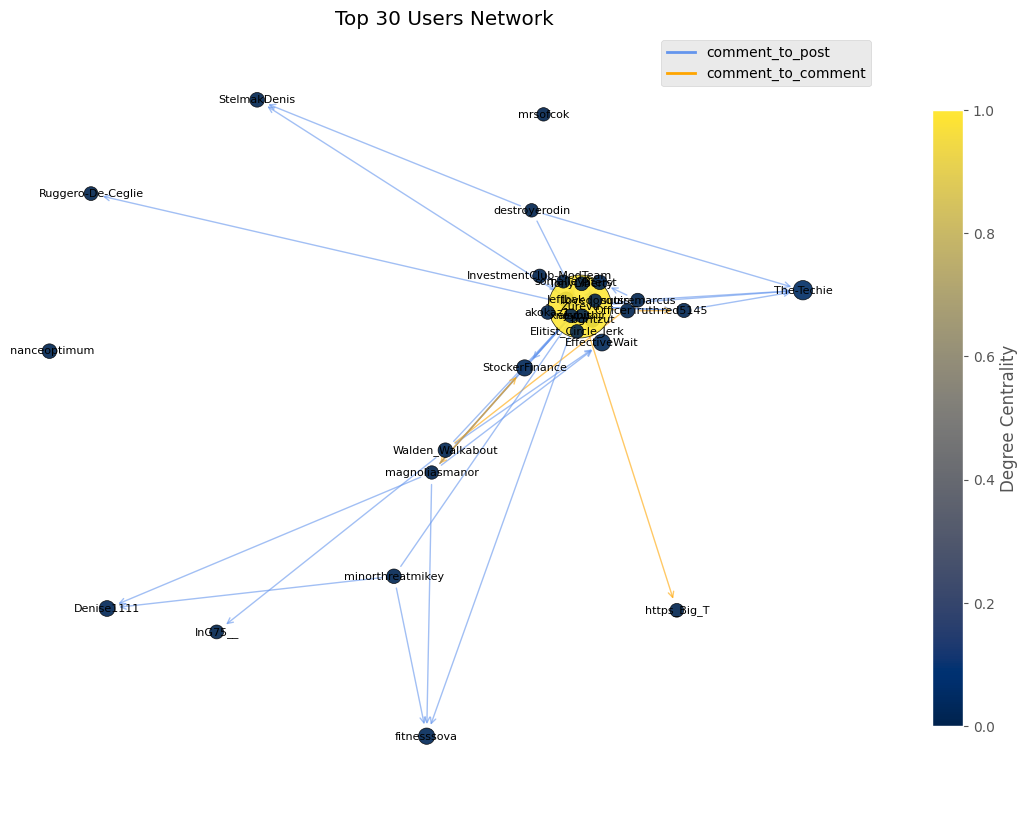

In [11]:
# Top 100 subgraph
plot_network(G_main, top_n=100, custom_title="Top 100 Users Network")
# Top 30 subgraph
plot_network(G_main, top_n=30, custom_title="Top 30 Users Network")

## 2.6 Basic Network Feature Analysis
I compute some statistics like node count, edge count, and density, using the helper function `basic_network_stats`.

In [12]:
stats_result = basic_network_stats(G_main)
print("Basic Network Stats:", stats_result)

Basic Network Stats: {'node_count': 7734, 'edge_count': 13473, 'density': 0.00022527455053689182}


## 2.7 Degree Distribution
I show histograms for out-degree and in-degree on `G_main`.

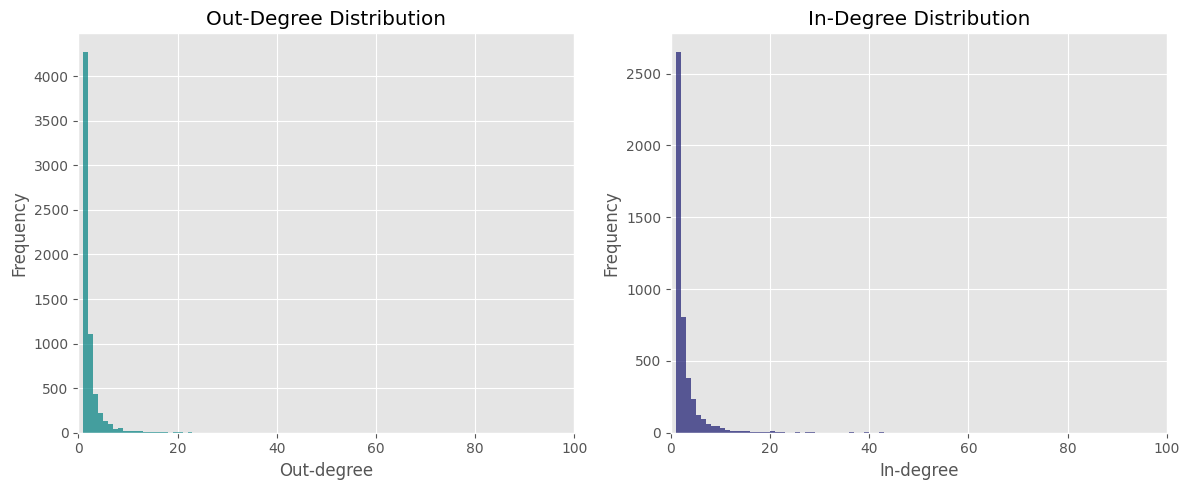

In [13]:
out_vals, in_vals = degree_distribution_values(G_main)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(out_vals, bins=range(1, min(max(out_vals)+2, 101),1), color='teal', alpha=0.7)
plt.xlim(0, 100) 
plt.title("Out-Degree Distribution")
plt.xlabel("Out-degree")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
plt.hist(in_vals, bins=range(1, min(max(out_vals)+2, 101),1), color='midnightblue', alpha=0.7)
plt.xlim(0, 100) 
plt.title("In-Degree Distribution")
plt.xlabel("In-degree")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

## 2.8 Connectivity Analysis
I examine the number of weakly and strongly connected components.

In [14]:
conn_info = connectivity_analysis(G_main)
print("Weakly connected components:", conn_info['weak_cc_count'])
print("Strongly connected components:", conn_info['strong_cc_count'])

Weakly connected components: 195
Strongly connected components: 5105


## 2.9 Path Analysis
I check the average shortest path length in the largest weakly connected component.

In [15]:
avg_path_len = path_analysis(G_main)
if avg_path_len is not None:
    print("Average path length in largest WCC:", avg_path_len)
else:
    print("No average path length could be computed.")

Average path length in largest WCC: 4.406994174731264


## 2.10 Centrality Analysis
Centrality analysis is a core method for assessing the importance of nodes in network science.I compute degree, betweenness, eigenvector, and closeness centralities metrics cross-validated to more fully identify key players in the network

In [16]:
c_dict = compute_centralities(G_main)
centrality_results = c_dict
key_users = identify_key_users(centrality_results, top_n=20)

print("Top 20 by total degree:\n")
print(f"{'User':<20} {'Total':<10}")
print("-" * 30)
deg_sorted = sorted(centrality_results['degree'].items(), key=lambda x: x[1], reverse=True)[:20]
for usr, degval in deg_sorted:
    print(f"{usr:<20} {degval:<10}")

if 'betweenness' in centrality_results and centrality_results['betweenness']:
    bet_sorted = sorted(centrality_results['betweenness'].items(), key=lambda x: x[1], reverse=True)[:20]
    print("\nTop 20 by betweenness:\n")
    print(f"{'User':<20} {'Score':<10}")
    print("-" * 30)
    for usr, bval in bet_sorted:
        print(f"{usr:<20} {bval:.5f}")

if 'eigenvector' in centrality_results and centrality_results['eigenvector']:
    eig_sorted = sorted(centrality_results['eigenvector'].items(), key=lambda x: x[1], reverse=True)[:20]
    print("\nTop 20 by eigenvector:\n")
    print(f"{'User':<20} {'Score':<10}")
    print("-" * 30)
    for usr, evalv in eig_sorted:
        print(f"{usr:<20} {evalv:.5f}")

if 'closeness' in centrality_results and centrality_results['closeness']:
    clo_sorted = sorted(centrality_results['closeness'].items(), key=lambda x: x[1], reverse=True)[:20]
    print("\nTop 20 by closeness:\n")
    print(f"{'User':<20} {'Score':<10}")
    print("-" * 30)
    for usr, cval in clo_sorted:
        print(f"{usr:<20} {cval:.5f}")

Top 20 by total degree:

User                 Total     
------------------------------
Zurevu               2079      
The-Techie           150       
EffectiveWait        102       
fitnesssova          91        
StockerFinance       90        
Denise1111           82        
Jeffbak              72        
StelmakDenis         64        
financeoptimum       63        
Piterst              62        
Walden_Walkabout     62        
minorthreatmikey     62        
bgritzut             57        
red5145              57        
OfficerTruth         56        
squiremarcus         52        
InG75__              52        
TonyLiberty          52        
Ruggero-De-Ceglie    51        
InvestmentClub-ModTeam 51        

Top 20 by betweenness:

User                 Score     
------------------------------
Zurevu               0.25261
StockerFinance       0.01578
Jeffbak              0.01282
red5145              0.00948
vanvark              0.00922
minorthreatmikey     0.00815
dopexile

## 2.11 Key User Analysis
I demonstrate how to retrieve key users from the dictionary of centrality measures.

In [17]:
def key_users_analysis(centrality_results, top_n=20):
    """
    Identify key users who appear in multiple centrality rankings,
    limiting each metric to top_n users.
    """
    key_users = set()

    for metric, user_map in centrality_results.items():
        if not user_map:
            continue
        # Sort the dictionary by value, descending, and keep only top N
        sorted_pairs = sorted(user_map.items(), key=lambda x: x[1], reverse=True)[:top_n]
        top_metric_users = [u for (u, _) in sorted_pairs]
        key_users.update(top_metric_users)

    # create role mappings for each user.
    user_roles = {}
    role_descriptions = {
        'degree': "High Interaction",
        'eigenvector': "High Influence",
        'betweenness': "Information Broker",
        'closeness': "Rapid Information Spreader"
    }

    # For each user in key_users, see which metrics they appear in (within top N).
    for user in key_users:
        roles = []
        for metric, user_map in centrality_results.items():
            if not user_map:
                continue
            # sort again or just do the same top N cut
            sorted_pairs = sorted(user_map.items(), key=lambda x: x[1], reverse=True)[:top_n]
            allowed_users = [u for (u, _) in sorted_pairs]
            if user in allowed_users:
                roles.append(role_descriptions[metric])
        user_roles[user] = roles

    return user_roles

print("\n KEY USERS COMPREHENSIVE ANALYSIS ")
try:
    user_roles = key_users_analysis(centrality_results, top_n=20)

    print(f"Total prominent users across all metrics: {len(user_roles)}")
    print("\n{:<20} {:<50}".format("USER", "ROLES"))
    print("-" * 70)
    for user, roles in user_roles.items():
        print("{:<20} {:<50}".format(user, ", ".join(roles)))

except Exception as e:
    print(f"Error in key users analysis: {str(e)}")


 KEY USERS COMPREHENSIVE ANALYSIS 
Total prominent users across all metrics: 55

USER                 ROLES                                             
----------------------------------------------------------------------
9bikes               Information Broker                                
StelmakDenis         High Interaction, Information Broker, Rapid Information Spreader
StockerFinance       High Interaction, Information Broker, High Influence, Rapid Information Spreader
Walden_Walkabout     High Interaction, Information Broker              
financeoptimum       High Interaction, Information Broker              
DarkHydra            High Influence                                    
mannaah              Rapid Information Spreader                        
wetkarma             High Influence                                    
Theauntgate          Rapid Information Spreader                        
Ruggero-De-Ceglie    High Interaction                                  
jordanbevan

# 3. Network Data Analysis

I now explore how super users behave, how the community evolves over time, and how exclusive certain user interactions can be.

## 3.1 Super Users in the Community
### 3.1.1 Super User Identification
I define super users by a certain centrality threshold, for instance, the top 5% of degree centrality.

In [18]:
def identify_super_users_comprehensive(
    G,
    interaction_df,
    submissions_df,
    threshold_percentile=95
):
    """
    Identify super users based on multiple metrics,
    including network degree centrality, comment frequency, and posting frequency.
    threshold_percentile indicates the cutoff (e.g., 95 => top 5% in each metric).
    """
    
    # 1) Degree centrality for the network
    deg_centrality = nx.degree_centrality(G)
    degree_values = list(deg_centrality.values())
    if degree_values:
        degree_cutoff = np.percentile(degree_values, threshold_percentile)
    else:
        degree_cutoff = 0

    # 2) Comment frequency
    comment_counts = interaction_df["source_user"].value_counts()
    comment_values = comment_counts.values
    if len(comment_values) > 0:
        comment_cutoff = np.percentile(comment_values, threshold_percentile)
    else:
        comment_cutoff = 0

    # 3) Posting frequency
    post_counts = submissions_df["author"].value_counts()
    post_values = post_counts.values
    if len(post_values) > 0:
        post_cutoff = np.percentile(post_values, threshold_percentile)
    else:
        post_cutoff = 0

    # Users must exceed all 3 thresholds to qualify as super users
    super_users = set()
    for user, deg_val in deg_centrality.items():
        user_comment_freq = comment_counts.get(user, 0)
        user_post_freq = post_counts.get(user, 0)
        if (
            deg_val >= degree_cutoff
            and user_comment_freq >= comment_cutoff
            and user_post_freq >= post_cutoff
        ):
            super_users.add(user)

    threshold_info = {
        "degree_cutoff": degree_cutoff,
        "comment_cutoff": comment_cutoff,
        "posting_cutoff": post_cutoff,
        "super_user_count": len(super_users)
    }
    print(f"Identified {len(super_users)} super users (comprehensive).")

    return super_users, threshold_info

super_users_comp, threshold_info = identify_super_users_comprehensive(
    G_main, 
    interaction_df, 
    submissions_df,
    threshold_percentile=95
)

Identified 37 super users (comprehensive).


### 3.1.2 Super User Basic Characteristics
I check how often super users interact, the types of interactions, etc.

Identified 37 super users (comprehensive).

Metrics for super users (head):
             user  degree_centrality  comment_frequency  posting_frequency
0    StelmakDenis           0.008276                 15                115
1  StockerFinance           0.011638                 45                 42
2  financeoptimum           0.008147                 21                 30
3     AxecapitalM           0.002974                 20                  6
4         kurt_FI           0.003750                 21                 23

Interaction type distribution among super users:
type
comment_to_post       60.819277
comment_to_comment    39.180723
Name: proportion, dtype: float64


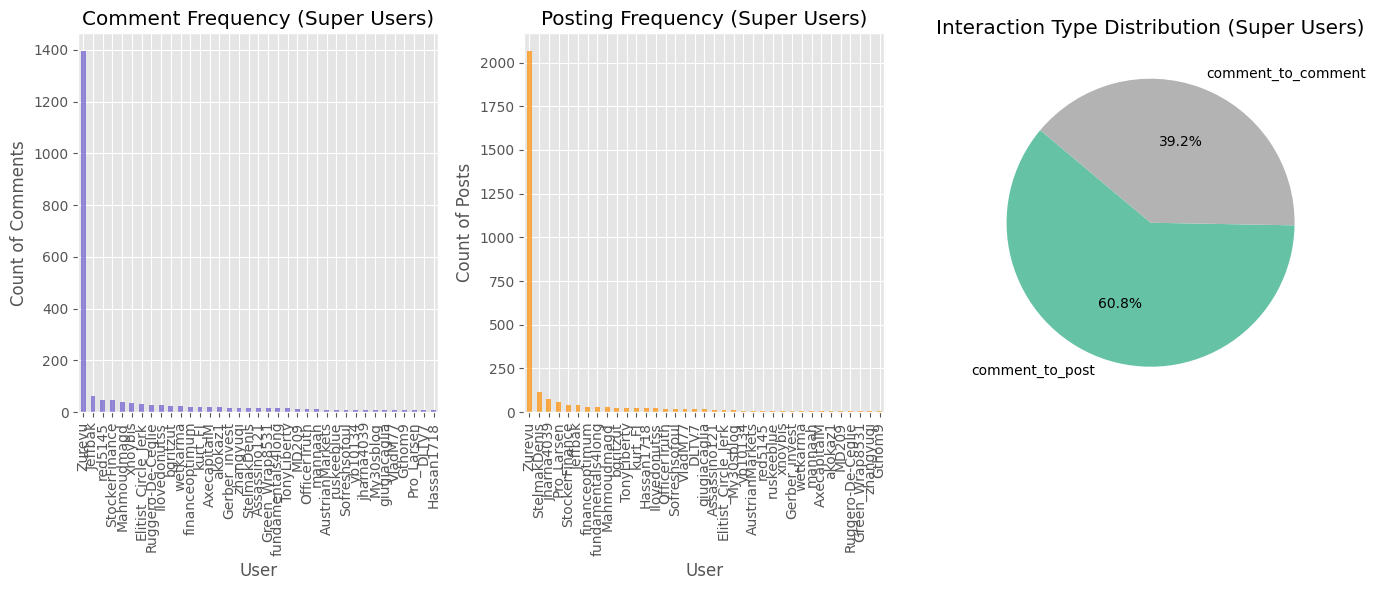

In [19]:
def analyze_super_user_basics(super_users, G, interaction_df, submissions_df):
    
    # 1) Prepare data sources
    deg_cent = nx.degree_centrality(G)                                # user -> degree centrality
    comment_counts = interaction_df["source_user"].value_counts()     # user -> # of comments
    post_counts = submissions_df["author"].value_counts()             # user -> # of posts

    # 2) Build a sub-DataFrame for super user interactions only
    super_interactions = interaction_df[interaction_df["source_user"].isin(super_users)]
    
    # 3) For each super user, retrieve these metrics
    user_metric_list = []
    for u in super_users:
        dc = deg_cent.get(u, 0)               # degree centrality
        c_freq = comment_counts.get(u, 0)     # comment frequency
        p_freq = post_counts.get(u, 0)        # posting frequency
        user_metric_list.append((u, dc, c_freq, p_freq))
    
    # Create a DataFrame to hold all metrics
    df_metrics = pd.DataFrame(
        user_metric_list, 
        columns=["user", "degree_centrality", "comment_frequency", "posting_frequency"]
    )

    # 4) Calculate how many comment_to_post vs. comment_to_comment exist among super users
    interaction_type_dist = super_interactions["type"].value_counts(normalize=True)*100
    
    return df_metrics, interaction_type_dist

super_users_comprehensive, threshold_info = identify_super_users_comprehensive(
    G_main,
    interaction_df,
    submissions_df,
    threshold_percentile=95
)

df_su_metrics, su_type_dist = analyze_super_user_basics(
    super_users_comprehensive, 
    G_main, 
    interaction_df, 
    submissions_df
)

# Show a snippet of the DataFrame
print("\nMetrics for super users (head):")
print(df_su_metrics.head())

print("\nInteraction type distribution among super users:")
print(su_type_dist)

# Visualization
plt.figure(figsize=(14, 6))

# Sort by comment_frequency descending
df_su_metrics_sorted_comments = df_su_metrics.sort_values("comment_frequency", ascending=False).set_index("user")

# Sort by posting_frequency descending
df_su_metrics_sorted_posts = df_su_metrics.sort_values("posting_frequency", ascending=False).set_index("user")

# Left subplot: bar chart for comment frequency (super users)
plt.subplot(1, 3, 1)
df_su_metrics_sorted_comments["comment_frequency"].plot(
    kind="bar",
    color="slateblue",
    alpha=0.7
)
plt.title("Comment Frequency (Super Users)")
plt.xlabel("User")
plt.ylabel("Count of Comments")
plt.xticks(rotation=90)  # avoid overlap

# Middle subplot: bar chart for posting frequency (super users)
plt.subplot(1, 3, 2)
df_su_metrics_sorted_posts["posting_frequency"].plot(
    kind="bar",
    color="darkorange",
    alpha=0.7
)
plt.title("Posting Frequency (Super Users)")
plt.xlabel("User")
plt.ylabel("Count of Posts")
plt.xticks(rotation=90)

# Right subplot: pie chart of interaction type
plt.subplot(1, 3, 3)
su_type_dist.plot(
    kind="pie",
    autopct="%.1f%%",
    startangle=140,
    cmap="Set2"
)
plt.title("Interaction Type Distribution (Super Users)")
plt.ylabel("") 

plt.tight_layout()
plt.show()

### 3.1.3 Community Cohesion Analysis
I compare the network's basic cohesion metrics before and after removing super users.

In [20]:
def measure_cohesion(G):
    # Measures average clustering, density.
    c = nx.average_clustering(G.to_undirected())
    d = nx.density(G)
    return {'clustering': c, 'density': d}

cohesion_original = measure_cohesion(G_main)

super_user_set, threshold_info = identify_super_users_comprehensive(
    G_main,
    interaction_df,
    submissions_df,
    threshold_percentile=95
)

G_no_super = G_main.copy()
G_no_super.remove_nodes_from(super_user_set)
cohesion_no_super = measure_cohesion(G_no_super)

print("Cohesion with super users:", cohesion_original)
print("Cohesion without super users:", cohesion_no_super)

Identified 37 super users (comprehensive).
Cohesion with super users: {'clustering': 0.058388933603925844, 'density': 0.00022527455053689182}
Cohesion without super users: {'clustering': 0.02658845956704744, 'density': 0.00017197279929513268}


### 3.1.4 Super User Influence Analysis
I check betweenness/eigenvector scores among super users only, to see if they are truly influential in terms of bridging or having global influence.

In [21]:
def analyze_super_influence(G, su_set, cdict):
    b_map = cdict.get('betweenness', {})
    e_map = cdict.get('eigenvector', {})
    su_b = [b_map[u] for u in su_set if u in b_map]
    su_e = [e_map[u] for u in su_set if u in e_map]
    result = {}
    if su_b:
        result['avg_betweenness'] = np.mean(su_b)
    else:
        result['avg_betweenness'] = 0
    if su_e:
        result['avg_eigenvector'] = np.mean(su_e)
    else:
        result['avg_eigenvector'] = 0
    return result

influence_su = analyze_super_influence(G_main, super_user_set, c_dict)
print("Influence among super users:", influence_su)

Influence among super users: {'avg_betweenness': 0.01019583356509751, 'avg_eigenvector': 0.03462245575647072}


## 3.2 User Group Behavior over Time
### 3.2.1 Time Data Preparation
I want to see how user activity changes over time. I transform the `timestamp` in `interaction_df` into year-month or day.

In [22]:
def prepare_time_data(int_df):
    df = int_df.copy()
    df['date_only'] = df['timestamp'].dt.date
    df['year_month'] = df['timestamp'].dt.to_period('M')
    return df

time_df = prepare_time_data(interaction_df)
time_df.head()

,source_user,target_user,type,post_id,timestamp,date_only,year_month
0,hobbitskill,Zurevu,comment_to_post,p6dut,2012-02-01 18:13:16,2012-02-01,2012-02
1,withacupofcoffee,hobbitskill,comment_to_comment,p6dut,2012-02-01 18:15:16,2012-02-01,2012-02
2,hobbitskill,Zurevu,comment_to_post,p6dut,2012-02-01 19:14:11,2012-02-01,2012-02
3,Zurevu,hobbitskill,comment_to_comment,p6dut,2012-02-01 19:41:29,2012-02-01,2012-02
4,Zurevu,bobbyt2012,comment_to_post,p6fpo,2012-02-01 20:20:24,2012-02-01,2012-02


### 3.2.2 Activity Over Time
I calculate how many interactions happen each day or month.

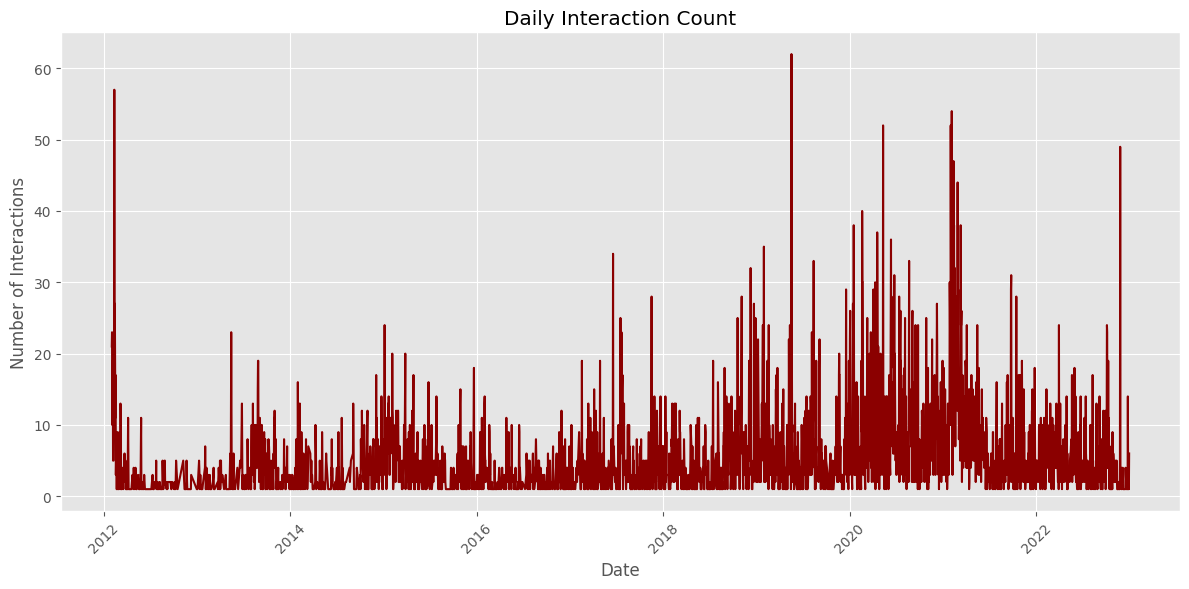

In [23]:
daily_counts = time_df.groupby('date_only').size().reset_index(name='interaction_count')
plt.figure(figsize=(12,6))
plt.plot(daily_counts['date_only'], daily_counts['interaction_count'], color='darkred')
plt.title("Daily Interaction Count")
plt.xlabel("Date")
plt.ylabel("Number of Interactions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 3.2.3 Interaction Pattern Changes
I could see if direct replies vs. nested replies changes over time, or super user vs. normal user. I show grouping by month plus interaction type.

Monthly interaction pattern:
type        comment_to_comment  comment_to_post
year_month                                     
2012-02                    197              108
2012-03                     55               44
2012-04                     20               17
2012-05                     24               23
2012-06                      3               11


<Figure size 1200x600 with 0 Axes>

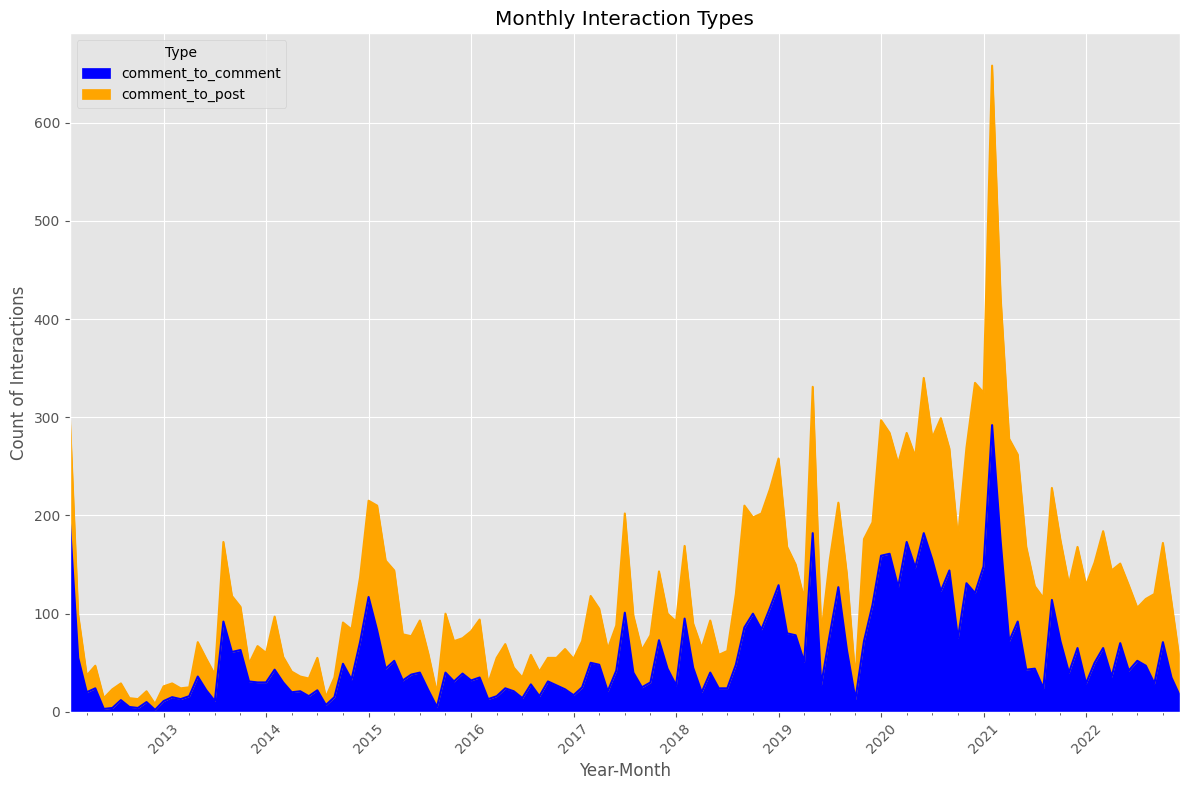

In [24]:
time_df['month_interaction_type'] = time_df.groupby(['year_month','type'])['source_user'].transform('count')
pattern_dist = time_df.groupby(['year_month','type']).size().unstack(fill_value=0)
print("Monthly interaction pattern:")
print(pattern_dist.head())

plt.figure(figsize=(12,6))
pattern_dist.plot(kind='area', color=['blue', 'orange'])
plt.title("Monthly Interaction Types")
plt.xlabel("Year-Month")
plt.ylabel("Count of Interactions")
plt.xticks(rotation=45)
plt.legend(title='Type')
plt.tight_layout()
plt.show()

## 3.3 Super User Behavior Exclusivity
I look at whether super users mostly interact with each other, or whether they interact with a broad range of people.

### 3.3.1 Interaction Diversity
Counts how many unique targets a super user has.

In [25]:
def interaction_diversity(int_df, su_set):
    sub_su = int_df[int_df['source_user'].isin(su_set)]
    diversity_list = []
    for su in su_set:
        block = sub_su[sub_su['source_user']==su]
        targets = set(block['target_user'])
        total = len(block)
        if total>0:
            ratio = len(targets)/total
        else:
            ratio = 0
        diversity_list.append((su, len(targets), ratio))
    df_div = pd.DataFrame(diversity_list, columns=['super_user','unique_targets','diversity_ratio'])
    return df_div

div_res = interaction_diversity(interaction_df, super_user_set)
print(div_res) 

             super_user  unique_targets  diversity_ratio
0          StelmakDenis              12         0.800000
1        StockerFinance              39         0.866667
2        financeoptimum              19         0.904762
3           AxecapitalM              13         0.650000
4               kurt_FI              16         0.761905
5            Hassan1718               5         0.714286
6               yb10134               6         0.666667
7               mannaah               8         0.727273
8              wetkarma              15         0.625000
9         Sofreshsofoul               6         0.666667
10            My30sblog               5         0.625000
11    Ruggero-De-Ceglie              24         0.857143
12                MD209               9         0.750000
13         Assassino121              14         0.933333
14             bgritzut              18         0.750000
15              Jeffbak              30         0.483871
16               Zurevu        

### 3.3.2 Interaction Target Analysis
I check how often super users interact with other super users, vs. regular users.

In [26]:
sub_su = interaction_df[interaction_df['source_user'].isin(super_user_set)]

# Ratio of super->super
ratio_super_super = (sub_su['target_user'].isin(super_user_set)).mean()

# Ratio of super->regular
ratio_super_regular = 1 - ratio_super_super

print("Ratio of super->super interactions:", ratio_super_super)
print("Ratio of super->regular interactions:", ratio_super_regular)

Ratio of super->super interactions: 0.09204819277108434
Ratio of super->regular interactions: 0.9079518072289157


### 3.3.3 Reply Patterns
Examines time intervals or other patterns of replies. I will demonstrate by computing average response time or something similar.

In [27]:
def analyze_reply_patterns(cdf, su_set):
    df = cdf.copy()
    df = df.sort_values(['link_id','created_utc'])
    df['time_diff'] = df.groupby('link_id')['created_utc'].diff().dt.total_seconds()
    df['is_super'] = df['author'].apply(lambda x: (x in su_set))
    su_block = df[df['is_super']==True]
    reg_block = df[df['is_super']==False]
    return su_block, reg_block

su_comments, reg_comments = analyze_reply_patterns(comments_clean, super_user_set)
print("Super user comments with valid time diffs:", su_comments['time_diff'].notna().sum())
print("Regular user comments with valid time diffs:", reg_comments['time_diff'].notna().sum())

Super user comments with valid time diffs: 1379
Regular user comments with valid time diffs: 12807


### 3.3.4 Reply Time Distribution Visualization
I plot a histogram or boxplot of response times for super vs. regular users.

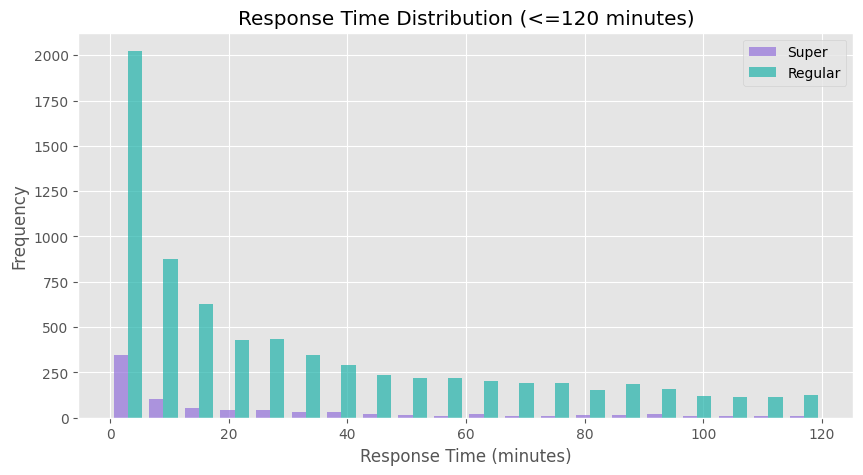

In [28]:
import numpy as np
su_times = su_comments['time_diff'].dropna()
reg_times = reg_comments['time_diff'].dropna()

max_min = 120  # Up to 120 minutes
su_filtered = su_times[su_times<=max_min*60].div(60)
reg_filtered = reg_times[reg_times<=max_min*60].div(60)

plt.figure(figsize=(10,5))
plt.hist([su_filtered, reg_filtered], bins=20, label=['Super','Regular'], color=['#9370DB','#20B2AA'], alpha=0.7)
plt.title("Response Time Distribution (<=120 minutes)")
plt.xlabel("Response Time (minutes)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### 3.3.5 Reply Content Analysis
I analyze the length of comments by analyzing the difference in response content between super users and regular users.

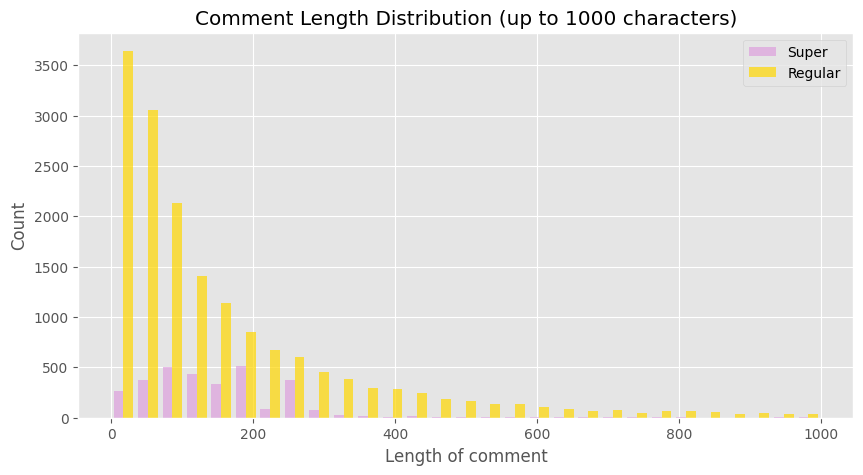

In [29]:
def analyze_comment_content_length(cdf, su_set):
    df = cdf.copy()
    df['comment_length'] = df['body'].astype(str).apply(len)
    df['is_super'] = df['author'].apply(lambda x: (x in su_set))
    su_len = df[df['is_super']==True]['comment_length']
    reg_len = df[df['is_super']==False]['comment_length']
    return su_len, reg_len

super_lengths, reg_lengths = analyze_comment_content_length(comments_clean, super_user_set)
plt.figure(figsize=(10,5))
bins = np.linspace(0,1000,30)
plt.hist([super_lengths, reg_lengths], bins=bins, alpha=0.7, label=['Super','Regular'], color=['#DDA0DD','#FFD700'])
plt.title("Comment Length Distribution (up to 1000 characters)")
plt.xlabel("Length of comment")
plt.ylabel("Count")
plt.legend()
plt.show()

### 3.3.6 Content Score Visualization
I could also compare comment scores for super vs. regular users.

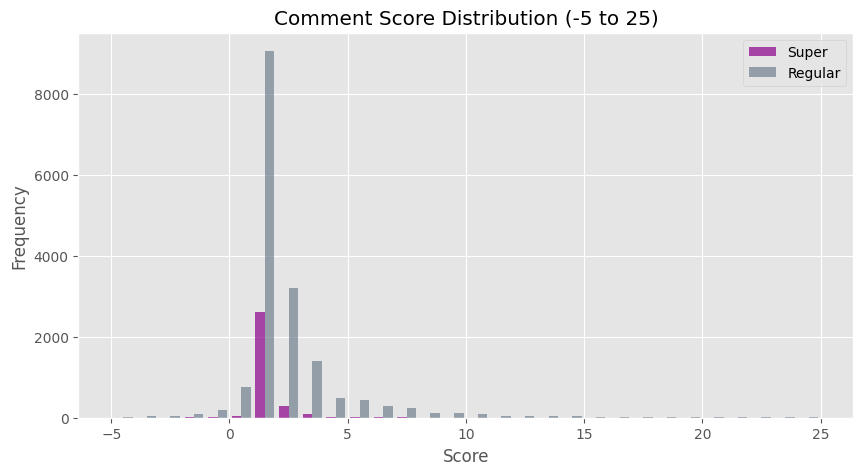

In [30]:
comments_clean['score'] = pd.to_numeric(comments_clean['score'], errors='coerce')
def compare_scores(cdf, su_set):
    df = cdf.copy()
    df['is_super'] = df['author'].apply(lambda x: (x in su_set))
    su_scores = df[df['is_super']==True]['score'].dropna()
    reg_scores = df[df['is_super']==False]['score'].dropna()
    return su_scores, reg_scores

sscores, rscores = compare_scores(comments_clean, super_user_set)

plt.figure(figsize=(10,5))
plt.hist([sscores, rscores], bins=range(-5,26,1), alpha=0.7, label=['Super','Regular'], color=['#8B008B','#708090'])
plt.title("Comment Score Distribution (-5 to 25)")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# 4. Topic Analysis and Sentiment Analysis

I now deepening the topic modeling on all posts using NMF and PyLDAVis, exploring the time dimension, and combining the results with the existing network data. And I also perform a degree of sentiment analysis to explore how user sentiment affects engagement.

## 4.1 Topic Analysis with NMF and PyLDAVis
I use the entire post content. I combine `title + selftext` for each submission as the text to analyze. I perform an NMF model and also show a PyLDAVis result using LDA for visualization.

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.lda_model
import numpy as np

def combine_post_text(row):
    t = row.get('title','')
    st = row.get('selftext','')
    return f"{t}\n{st}"

posts_cleaned = submissions_clean.copy()
posts_cleaned['combined_text'] = posts_cleaned.apply(combine_post_text, axis=1)

def simple_clean(txt):
    txt = txt.lower()
    txt = re.sub(r'[^a-z\s]', ' ', txt)
    tokens = txt.split()
    tokens = [w for w in tokens if w not in stop_words]
    return " ".join(tokens)

posts_cleaned['processed_text'] = posts_cleaned['combined_text'].apply(simple_clean)
print("Number of posts used in topic analysis:", len(posts_cleaned))

# NMF model
n_topics = 10
tfidf_vec = TfidfVectorizer(min_df=5, max_df=0.9)
X_tfidf = tfidf_vec.fit_transform(posts_cleaned['processed_text'])

nmf_model = NMF(n_components=n_topics, random_state=42, max_iter=200)
nmf_model.fit(X_tfidf)
print("NMF model fitted.")

def show_nmf_topics(model, feature_names, topn=10):
    for idx, topic_vec in enumerate(model.components_):
        top_indices = topic_vec.argsort()[::-1][:topn]
        top_terms = [feature_names[i] for i in top_indices]
        print(f"Topic {idx}: ", " ".join(top_terms))

vocab_feats = tfidf_vec.get_feature_names_out()
show_nmf_topics(nmf_model, vocab_feats, topn=10)

# LDA for PyLDAVis demonstration
lda_for_vis = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_for_vis.fit(X_tfidf)

term_frequency = np.asarray(X_tfidf.sum(axis=0)).flatten()
vocab = tfidf_vec.get_feature_names_out()

pyldavis_data = pyLDAvis.prepare(
    topic_term_dists=lda_for_vis.components_ / lda_for_vis.components_.sum(axis=1)[:, np.newaxis],
    doc_topic_dists=lda_for_vis.transform(X_tfidf),
    doc_lengths=[len(txt.split()) for txt in posts_cleaned['processed_text']],
    vocab=vocab,
    term_frequency=term_frequency
)

pyLDAvis_display = pyLDAvis.display(pyldavis_data)
pyLDAvis_display

Number of posts used in topic analysis: 13509
NMF model fitted.
Topic 0:  stock market analysis crash seeing video buy review price tips
Topic 1:  crypto important news jun may feb mar jul apr coinbase
Topic 2:  investment best property real estate opportunities uk strategy cherokee partners
Topic 3:  money online earn making ways want tips way best home
Topic 4:  buffett warren berkshire hathaway billion advice buffet portfolio charlie value
Topic 5:  invest best real estate funds mutual now time know india
Topic 6:  investing real know estate value start beginners funds tips mutual
Topic 7:  nifty bank levels amp stock recommendations watch daily weekly america
Topic 8:  com amp will new https company www trading can bitcoin
Topic 9:  buy stocks analysis now best top dividend sell gold penny


## 4.1.2 Topic Distribution Over Time
I compute the main topic for each post using the NMF model, then observe how these topics vary by month.

Topic distribution by year_month:
nmf_topic   0  1  2  3  4  5  6  7   8  9
year_month                               
2012-02     2  0  3  2  2  0  1  0  34  2
2012-03     1  0  2  1  0  0  0  0   8  1
2012-04     1  0  0  0  0  0  0  0   4  0
2012-05     5  2  0  0  0  0  1  0  12  5
2012-06     2  0  1  0  0  4  2  0  21  6


<Figure size 1200x600 with 0 Axes>

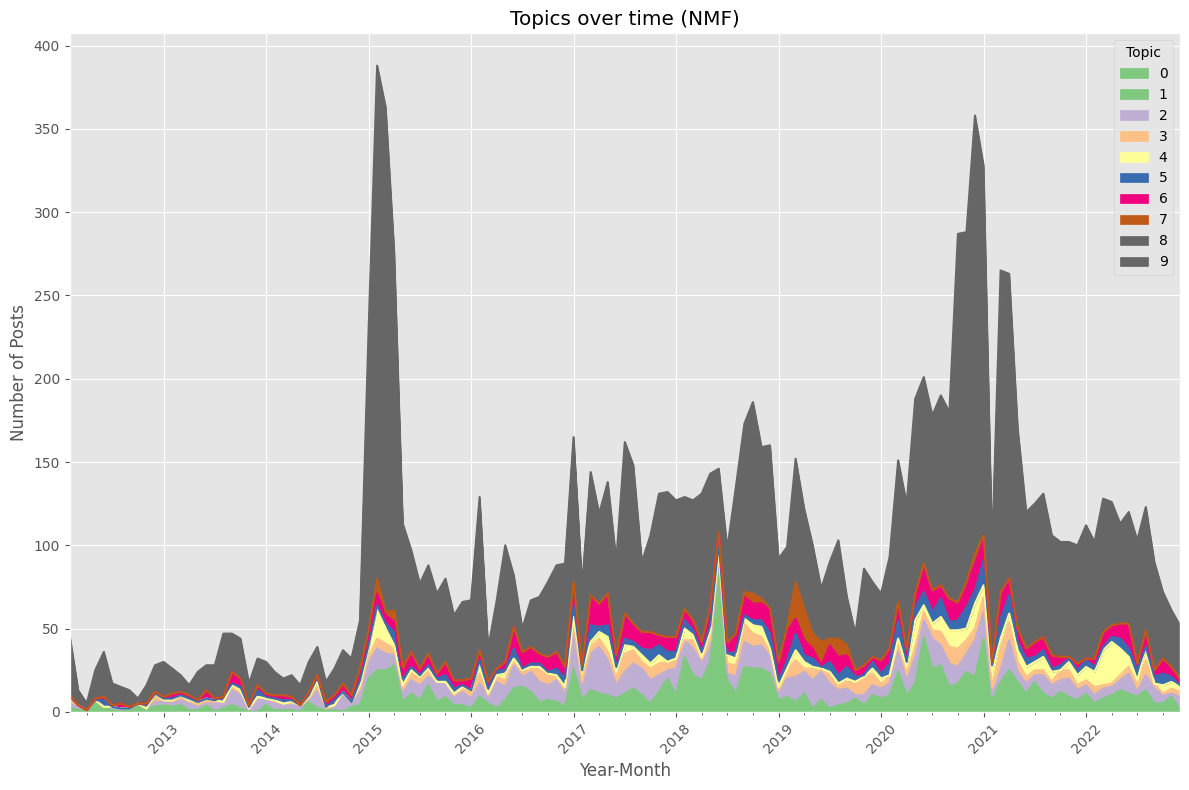

In [32]:
posts_cleaned['year_month'] = posts_cleaned['created_utc'].dt.to_period('M')
W_nmf = nmf_model.transform(X_tfidf)
dominant_topic = W_nmf.argmax(axis=1)
posts_cleaned['nmf_topic'] = dominant_topic

grouped_tm = posts_cleaned.groupby(['year_month','nmf_topic']).size().unstack(fill_value=0)
print("Topic distribution by year_month:")
print(grouped_tm.head())

plt.figure(figsize=(12,6))
grouped_tm.plot(kind='area', cmap='Accent')
plt.title("Topics over time (NMF)")
plt.xlabel("Year-Month")
plt.ylabel("Number of Posts")
plt.xticks(rotation=45)
plt.legend(title='Topic')
plt.tight_layout()
plt.show()

### 4.1.3 Combining Topic Results with the Network
I see which authors produce content in each topic, mapping them to the graph to check if central users are dominating certain themes.

In [33]:
posts_cleaned['post_author'] = posts_cleaned['author']
topic_author = posts_cleaned[['post_author','nmf_topic']].copy()
topic_author_counts = topic_author.groupby(['nmf_topic','post_author']).size().reset_index(name='count')
print("Topic-Author counts sample:")
print(topic_author_counts.head(15))

for t in range(n_topics):
    subdf = topic_author_counts[topic_author_counts['nmf_topic']==t]
    top_5 = subdf.sort_values('count', ascending=False).head(5)
    print(f"\nTopic {t} top 5 authors:")
    print(top_5)

Topic-Author counts sample:
    nmf_topic           post_author  count
0           0          -Authorised-      1
1           0             8008Edwin      3
2           0      AESInternational      4
3           0             Aaron0522      4
4           0             Abdul5679      1
5           0        Aceofspades323      1
6           0          AchieverLife      1
7           0             AdelHikal      1
8           0        AffiliateLeakz      1
9           0  Agreeable_Entry_3872      1
10          0            Alan_Salih      3
11          0    AllThingsFinanceYT      2
12          0      AltStreetJournal      1
13          0          AndyMcConnel      1
14          0  Appropriate_Heat_452      1

Topic 0 top 5 authors:
     nmf_topic   post_author  count
216          0        Zurevu     87
476          0      zman1175     37
174          0  StelmakDenis     36
340          0      jtomaskl     32
49           0    Denise1111     21

Topic 1 top 5 authors:
     nmf_topic post_

## 4.2 Sentiment Analysis
I do two tasks:
1. Compare super users vs regular users in terms of post sentiment.
2. Investigate how different sentiment categories might affect the number of replies or interactions each post receives.

### 4.2.1 Defining Super Users and Post Sentiment
I already defined super users from a degree percentile. I compute compound sentiment for each post, then classify the post author as super or regular.

In [34]:
def compute_sentiment_vader(text):
    scores = sia.polarity_scores(text)
    return scores['compound']

posts_cleaned['post_sentiment'] = posts_cleaned['combined_text'].apply(compute_sentiment_vader)
posts_cleaned['user_type'] = posts_cleaned['post_author'].apply(
    lambda x: 'Super' if x in super_user_set else 'Regular'
)
print("Example post sentiment:")
print(posts_cleaned[['post_author','post_sentiment','user_type']].head())

Example post sentiment:
       post_author  post_sentiment user_type
0  oblivious_human          0.0000   Regular
1  kilzorthekilbot          0.9200   Regular
2  cantquitereddit          0.2500   Regular
3           ttg314          0.9781   Regular
4         Waterwoo          0.8162   Regular


#### Compare Sentiment Distribution for Super vs. Regular

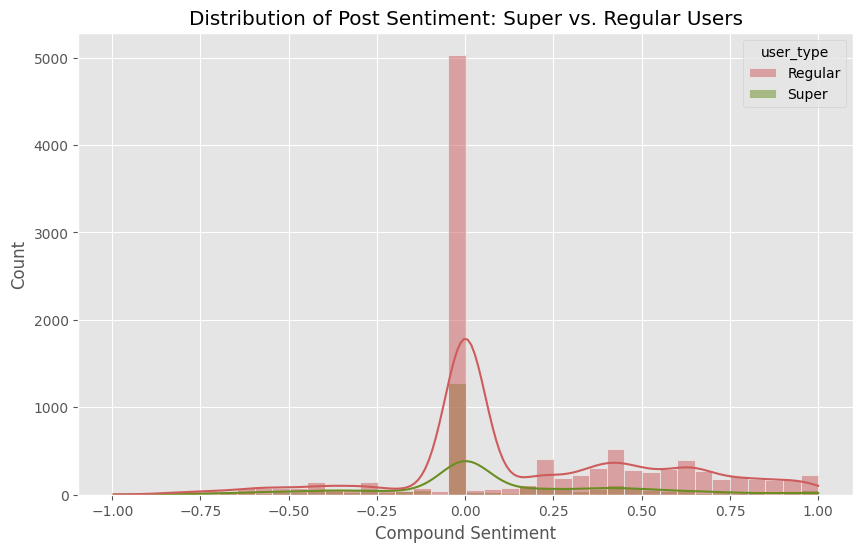

Average sentiment by user type:
user_type
Regular    0.180601
Super      0.081892
Name: post_sentiment, dtype: float64


In [35]:
plt.figure(figsize=(10,6))
sns.histplot(
    data=posts_cleaned,
    x='post_sentiment',
    hue='user_type',
    binwidth=0.05,
    kde=True,
    palette=['#CD5C5C', '#6B8E23']
)
plt.title("Distribution of Post Sentiment: Super vs. Regular Users")
plt.xlabel("Compound Sentiment")
plt.ylabel("Count")
plt.show()

avg_sent = posts_cleaned.groupby('user_type')['post_sentiment'].mean()
print("Average sentiment by user type:")
print(avg_sent)

### 4.2.2 Sentiment Influence on Engagement
I categorize post sentiment and see how many interactions each post gets from the `interaction_df`.

Engagement metrics by sentiment category:
                     mean  count
sentiment_cat                   
Negative         1.346596   1131
Neutral          0.831346   9143
Positive         2.202155   2691
Strong Negative  1.665441    544


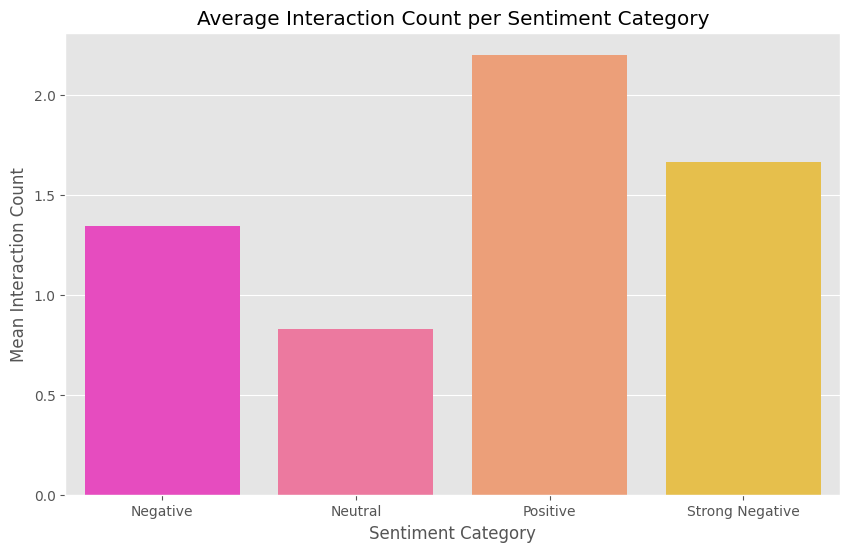

Completed sentiment vs. engagement analysis.


In [36]:
def sentiment_category(compound_score):
    if compound_score <= -0.5:
        return "Strong Negative"
    elif compound_score < 0:
        return "Negative"
    elif compound_score < 0.5:
        return "Neutral"
    else:
        return "Positive"

posts_cleaned['sentiment_cat'] = posts_cleaned['post_sentiment'].apply(sentiment_category)
post_inter_count = interaction_df.groupby('post_id')['source_user'].count().reset_index(name='interaction_count')
posts_merge = posts_cleaned.merge(post_inter_count, left_on='id', right_on='post_id', how='left')
posts_merge['interaction_count'] = posts_merge['interaction_count'].fillna(0)

sent_inter_group = posts_merge.groupby(['sentiment_cat'])['interaction_count'].agg(['mean','count'])
print("Engagement metrics by sentiment category:")
print(sent_inter_group)

plt.figure(figsize=(10,6))
sns.barplot(
    x=sent_inter_group.index,
    y=sent_inter_group['mean'],
    palette='spring'
)
plt.title("Average Interaction Count per Sentiment Category")
plt.xlabel("Sentiment Category")
plt.ylabel("Mean Interaction Count")
plt.show()

print("Completed sentiment vs. engagement analysis.")